# Word2Vec Tutorial
- https://github.com/nlintz/TensorFlow-Tutorials/blob/master/08_word2vec.ipynb
- 이 tutorial 을 따라해봅니다.

In [3]:
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
batch_size = 20

embedding_size = 2
num_sampled = 15

sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]

words = " ".join(sentences).split()

In [13]:
count = collections.Counter(words).most_common()
print("Word count", count[:5])

Word count [('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3)]


In [8]:
index_to_word = [i[0] for i in count]
word_to_index = {w: i for i, w in enumerate(index_to_word)}
vocab_size = len(word_to_index)
print("vocab size: ", vocab_size)

vocab size:  35


In [9]:
data = [word_to_index[word] for word in words]
print('Sample data', data[:10], [index_to_word[t] for t in data[:10]])

Sample data [5, 9, 10, 11, 12, 13, 5, 14, 15, 16] ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I']


In [20]:
cbow_pairs = []
for i in range(1, len(data) - 1):
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]])
print('Context pairs', cbow_pairs[:10])

Context pairs [[[5, 10], 9], [[9, 11], 10], [[10, 12], 11], [[11, 13], 12], [[12, 5], 13], [[13, 14], 5], [[5, 15], 14], [[14, 16], 15], [[15, 4], 16], [[16, 0], 4]]


In [19]:
skip_gram_pairs = []
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
print('skip-gram pairs', skip_gram_pairs[:5])

skip-gram pairs [[9, 5], [9, 10], [10, 9], [10, 11], [11, 10]]


In [21]:
def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data = []
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])
        y_data.append([skip_gram_pairs[i][1]])
    return x_data, y_data

print('Batches (x, y)', generate_batch(3))

Batches (x, y) ([2, 33, 17], [[0], [34], [1]])


In [26]:
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

nce_weights = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([vocab_size]))

loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocab_size))

train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

Instructions for updating:
Use tf.cast instead.


Loss at 0 20.775763
Loss at 10 12.740293
Loss at 20 4.4300537
Loss at 30 4.133914
Loss at 40 7.9839644
Loss at 50 3.5212505
Loss at 60 3.5379746
Loss at 70 3.52907
Loss at 80 3.3538327
Loss at 90 3.2420726


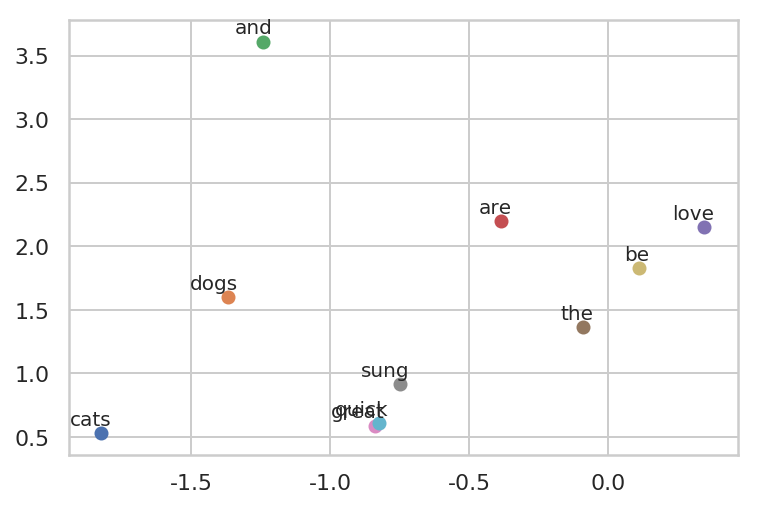

In [27]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss], feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        if step % 10 == 0:
            print("Loss at", step, loss_val)
    
    trained_embeddings = embeddings.eval()
    
if trained_embeddings.shape[1] == 2:
    labels = index_to_word[:10]
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')